## Experiments with the simplest model
* https://www.kaggle.com/code/egreblova/facial-expression-recognition-with-resnet-models/notebook

In [2]:
!pip install torch

In [3]:
!pip install torchvision

In [4]:
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.utils.data
import matplotlib.pyplot as plt

In [5]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [6]:
all_data = pd.read_csv("./data/fer2013.csv")

In [7]:
groups = [g for _, g in all_data.groupby('Usage')]
training_data = groups[2]
validation_data = groups[1]
testing_data = groups[0]

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
def make_dataloader(data, batch_size, shuffle):
    images, labels = data['pixels'], data['emotion']
    images = np.array([np.fromstring(image, np.uint8, sep=' ') for image in images]) / 255.0 # normalizing data to be between 0 and 1
    images = torch.FloatTensor(images.reshape(images.shape[0], 1, 48, 48)).to(device) # 1 color channel, 48x48 images
    dataset = torch.utils.data.TensorDataset(images, torch.LongTensor(np.array(labels)).to(device))
    return torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)

In [9]:
device

device(type='cuda', index=0)

In [10]:
train_loader = make_dataloader(training_data, 100, True)
valid_loader = make_dataloader(validation_data, 100, False)

In [11]:
%matplotlib inline

Fear


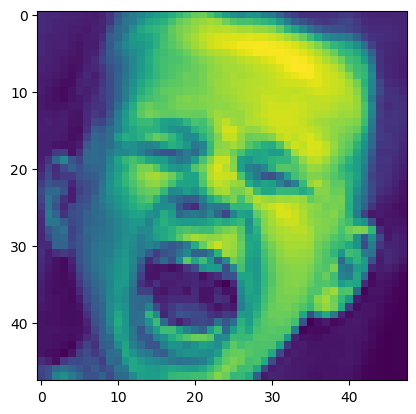

In [12]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(label_names[labels[1]])
plt.imshow(images[1].view(48, 48).cpu());

In [13]:
import torch.nn as nn
def adjust_model(model):
    model.conv1 = nn.Conv2d(1, 64, model.conv1.kernel_size, model.conv1.stride, model.conv1.padding, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 7, bias=False)
    return model

In [17]:
epochs = 100

In [15]:
def eval_model(model, data_loader, criterion):
    model.eval()
    with torch.no_grad():
        accuracy = 0
        loss = 0
        for data, labels in data_loader:
            output = model(data)
            _, preds = torch.max(output.data, 1)
            equals = (preds == labels).cpu()
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            loss += criterion(output, labels).data.cpu()
        return accuracy/len(data_loader), loss/len(data_loader)
        
def train_model(model, criterion, optimizer, data_loader, eval_loader):
    model = model.to(device)
    test_accuracy_history = []
    test_loss_history = []
    for epoch in range(epochs):
        print(f"Training epoch {epoch}")
        
        model.train()
        for data, labels in data_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
        accuracy, loss = eval_model(model, eval_loader, criterion)
        print(f"Acc: {accuracy}, loss: {loss}")
        test_accuracy_history.append(accuracy)
        test_loss_history.append(loss)
    return test_accuracy_history, test_loss_history

In [18]:
from torch import optim
from torchvision import models
criterion = nn.CrossEntropyLoss()
lrs = [0.1, 0.01]
models_1 = [adjust_model(models.resnet18()) for i in range(len(lrs))]
optimizers = [optim.SGD(models_1[i].parameters(), lr=lrs[i], momentum=0.9) for i in range(len(lrs))]

In [19]:
for i in range(len(lrs)):
    accuracy, loss = train_model(models_1[i], criterion, optimizers[i], train_loader, valid_loader)
    torch.save(accuracy, 'ResNet18_lr_'+ str(lrs[i]) + '_accuracy.pt')
    torch.save(loss, 'ResNet18_lr_'+ str(lrs[i]) + '_loss.pt') 
    torch.save(models_1[i], 'ResNet18_lr_'+ str(lrs[i]) + '_model.pt')

Training epoch 0
Acc: 0.2651310861110687, loss: 1.7801833152770996
Training epoch 1
Acc: 0.3423158551255862, loss: 1.6431870460510254
Training epoch 2
Acc: 0.3479026257991791, loss: 1.6507219076156616
Training epoch 3
Acc: 0.1754119855662187, loss: 2.837606191635132
Training epoch 4


KeyboardInterrupt: 

In [35]:
resnet18_accuracy = [torch.load("./models/ResNet18_lr_0.1_accuracy.pt"), 
            torch.load("./models/ResNet18_lr_0.01_accuracy.pt")
]

resnet18_loss = [torch.load("./models/ResNet18_lr_0.1_loss.pt"),
                 torch.load("./models/ResNet18_lr_0.01_loss.pt"),
]

In [36]:
colors = ['skyblue', 'red', 'green', 'violet', 'magenta']

def make_plots(accuracy, losses, title1, title2, lbls):
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.title.set_text(title1)
    for i in range(len(accuracy)):
        ax1.plot(range(epochs),accuracy[i], color=colors[i],label=lbls[i])
    ax1.set_xlabel('epochs');
    ax1.set_ylabel('accuracy')
    ax1.legend(loc='lower right')

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.title.set_text(title2)
    for i in range(len(losses)):
        ax2.plot(range(epochs),losses[i], color=colors[i],label=lbls[i])
    ax2.set_xlabel('epochs');
    ax2.set_ylabel('loss')
    ax2.legend(loc='upper left')
    plt.subplots_adjust(wspace=0.35, right=2.0)
    plt.show()

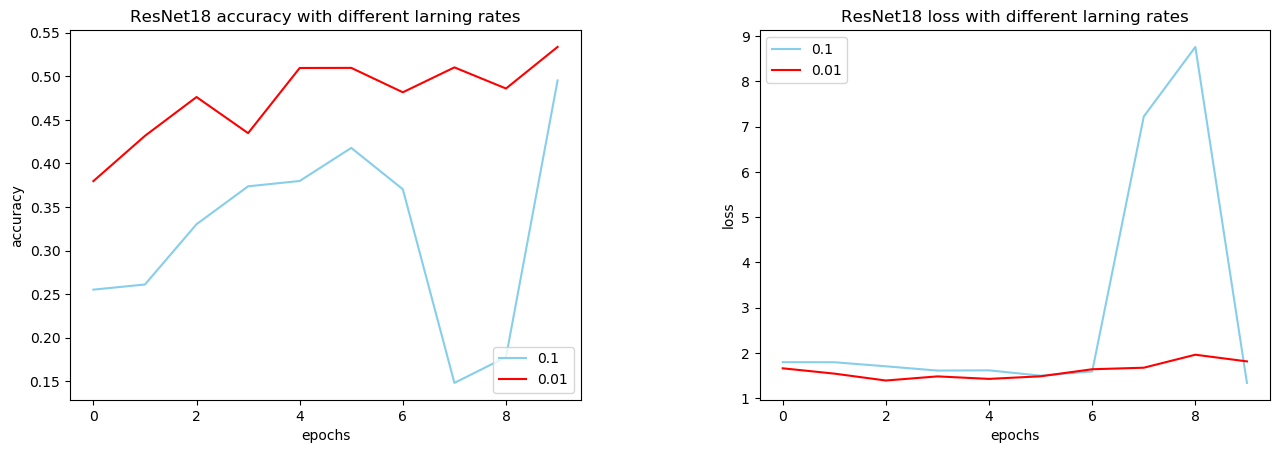

In [37]:
title1 = 'ResNet18 accuracy with different larning rates'
title2 = 'ResNet18 loss with different larning rates'
make_plots(resnet18_accuracy, resnet18_loss, title1, title2, [str(lr) for lr in lrs])

In [33]:
test_loader = make_dataloader(testing_data, 100, False)
model_best = torch.load('./models/ResNet18_lr_0.1_model.pt')
acc, losses = eval_model(model_best, test_loader, criterion)

In [34]:
print('Test accuracy: ' + str(acc*100))

Test accuracy: 49.904805670181915
